HH Efferent Neuron Model During Muscle Constraction

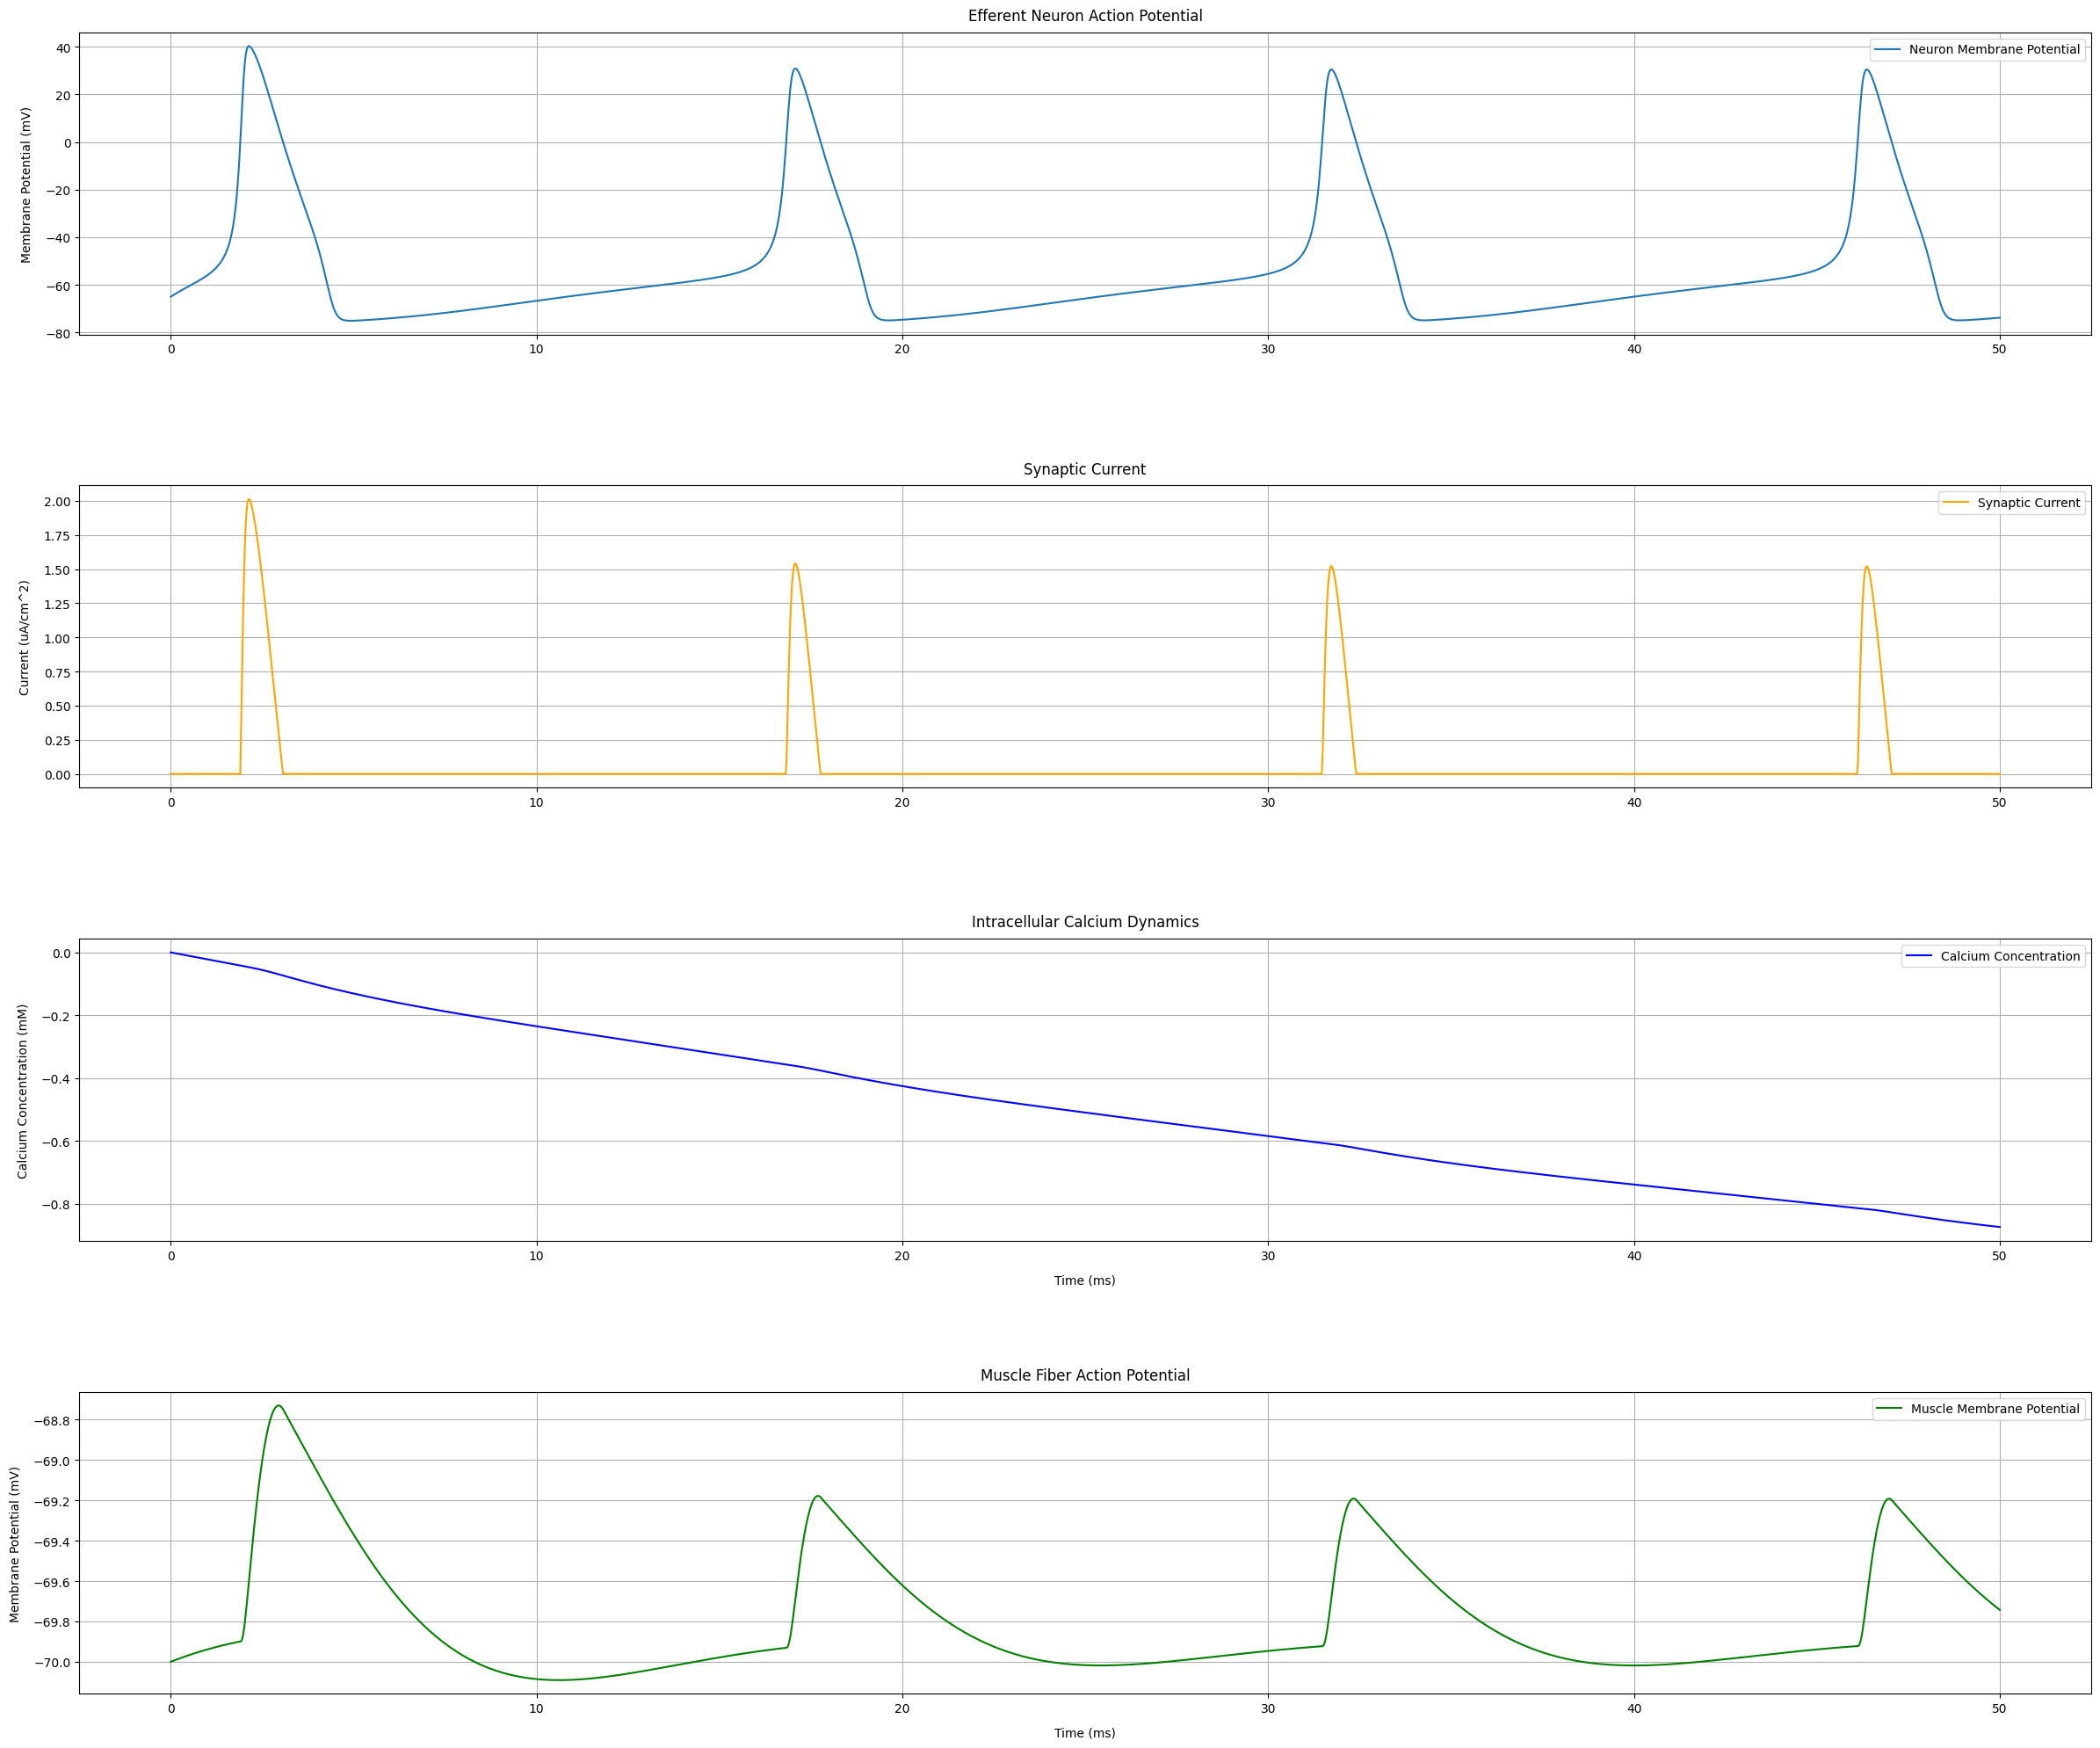

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Constants for Hodgkin-Huxley Neuron
C_m = 1.0  # Membrane capacitance, uF/cm^2
g_Na = 120.0  # Maximum conductances, mS/cm^2
g_K = 36.0
g_L = 0.3
E_Na = 50.0  # Reversal potentials, mV
E_K = -77.0
E_L = -54.4

# Gating Variable Functions
def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# Hodgkin-Huxley equations for the neuron
def hh_model(y, t, I_ext):
    if I_ext < 0:
        raise ValueError("External current (I_ext) must be non-negative.")

    V, m, h, n = y
    dVdt = (I_ext - (g_Na * m**3 * h * (V - E_Na) + g_K * n**4 * (V - E_K) + g_L * (V - E_L))) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return [dVdt, dmdt, dhdt, dndt]

# Synaptic parameters
g_syn = 0.05  # Synaptic conductance, mS/cm^2
E_syn = 0.0   # Synaptic reversal potential, mV

# Muscle fiber parameters
g_Na_m = 100.0
g_K_m = 40.0
g_L_m = 0.2
E_Na_m = 50.0
E_K_m = -85.0
E_L_m = -60.0

# Calcium dynamics parameters
tau_Ca = 80.0  # Time constant for calcium removal, ms
f_Ca = 0.1     # Scaling factor for calcium influx
Ca_rest = 0.0001  # Resting calcium concentration, mM

def muscle_model(y, t, I_syn):
  if I_syn < 0:
        raise ValueError("Synaptic current (I_syn) must be non-negative.")
  V_m, m_m, h_m, n_m, Ca = y
  I_Ca = g_Na_m * m_m**3 * h_m * (V_m - E_Na_m)  # Simplified calcium influx

    # Muscle action potential dynamics
  dVdt = (I_syn - (g_Na_m * m_m**3 * h_m * (V_m - E_Na_m) +
                     g_K_m * n_m**4 * (V_m - E_K_m) +
                     g_L_m * (V_m - E_L_m))) / C_m
  dmdt = alpha_m(V_m) * (1 - m_m) - beta_m(V_m) * m_m
  dhdt = alpha_h(V_m) * (1 - h_m) - beta_h(V_m) * h_m
  dndt = alpha_n(V_m) * (1 - n_m) - beta_n(V_m) * n_m

    # Calcium dynamics
  dCadt = -Ca / tau_Ca + f_Ca * I_Ca

  return [dVdt, dmdt, dhdt, dndt, dCadt]

# Initial conditions for neuron
V0 = -65.0  # Resting potential
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
y0_neuron = [V0, m0, h0, n0]

# Initial conditions for muscle fiber
V0_m = -70.0  # Muscle resting potential
m0_m = alpha_m(V0_m) / (alpha_m(V0_m) + beta_m(V0_m))
h0_m = alpha_h(V0_m) / (alpha_h(V0_m) + beta_h(V0_m))
n0_m = alpha_n(V0_m) / (alpha_n(V0_m) + beta_n(V0_m))
y0_muscle = [V0_m, m0_m, h0_m, n0_m]

# Initial conditions for muscle model with calcium dynamics
Ca0 = Ca_rest  # Initial calcium concentration, mM
y0_muscle = [V0_m, m0_m, h0_m, n0_m, Ca0]

# Time vector
t = np.linspace(0, 50, 2000)  # 50 ms

# External current for neuron
I_ext = 10  # uA/cm^2

# Solve for neuron action potential
neuron_solution = odeint(hh_model, y0_neuron, t, args=(I_ext,))
V_neuron = neuron_solution[:, 0]

# Synaptic current (simple approximation: active when neuron spikes)
def synaptic_current(V_pre):
    return g_syn * (V_pre - E_syn) if V_pre > 0 else 0

I_synaptic = np.array([synaptic_current(V) for V in V_neuron])

# Solve for muscle action potential with calcium dynamics
muscle_solution = np.zeros((len(t), len(y0_muscle)))
muscle_solution[0] = y0_muscle  # Set initial conditions

for i in range(1, len(t)):
    # Use I_synaptic[i-1] to get the current value for the previous time step
    muscle_solution[i] = odeint(
        muscle_model,
        muscle_solution[i-1],
        [t[i-1], t[i]],
        args=(I_synaptic[i-1],)
    )[1]

V_muscle = muscle_solution[:, 0]
Ca_concentration = muscle_solution[:, 4]

# Plotting the results
plt.figure(figsize=(24, 20))

# Neuron action potential
plt.subplot(4, 1, 1)
plt.plot(t, V_neuron, label="Neuron Membrane Potential")
plt.title("Efferent Neuron Action Potential", pad=10)
plt.ylabel("Membrane Potential (mV)", labelpad=10)
plt.grid()
plt.legend()

# Synaptic current
plt.subplot(4, 1, 2)
plt.plot(t, I_synaptic, label="Synaptic Current", color="orange")
plt.title("Synaptic Current", pad=10)
plt.ylabel("Current (uA/cm^2)", labelpad=10)
plt.grid()
plt.legend()

# Calcium concentration
plt.subplot(4, 1, 3)
plt.plot(t, Ca_concentration, label="Calcium Concentration", color="blue")
plt.title("Intracellular Calcium Dynamics", pad=10)
plt.xlabel("Time (ms)", labelpad=10)
plt.ylabel("Calcium Concentration (mM)", labelpad=10)
plt.grid()
plt.legend()

# Muscle fiber action potential
plt.subplot(4, 1, 4)
plt.plot(t, V_muscle, label="Muscle Membrane Potential", color="green")
plt.title("Muscle Fiber Action Potential", pad=10)
plt.xlabel("Time (ms)", labelpad=10)
plt.ylabel("Membrane Potential (mV)", labelpad=10)
plt.grid()
plt.legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()


Cleaned Up Code

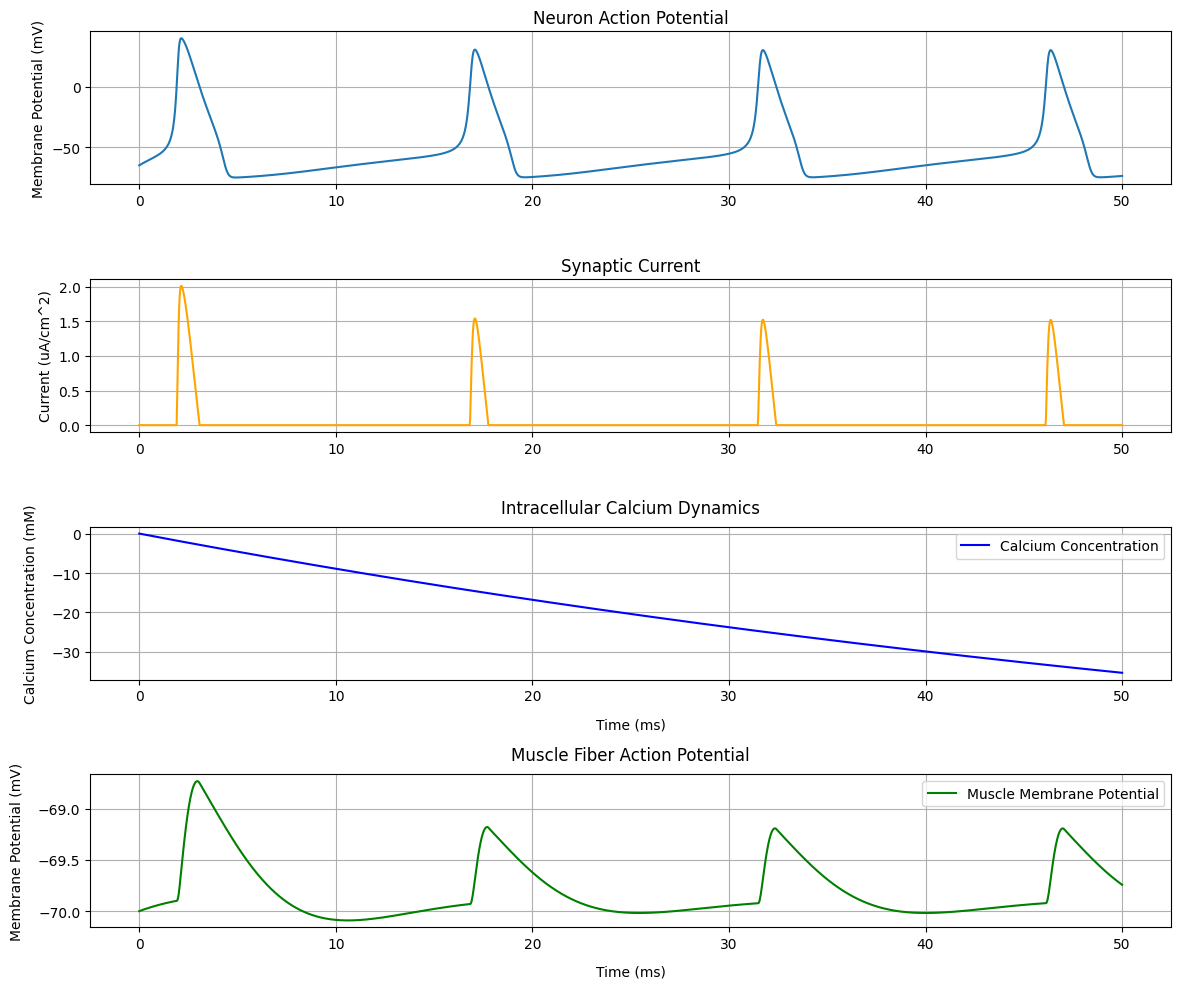

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Constants
C_m = 1.0  # Membrane capacitance, uF/cm^2
g_Na, g_K, g_L = 120.0, 36.0, 0.3  # Conductances for neuron
E_Na, E_K, E_L = 50.0, -77.0, -54.4  # Reversal potentials for neuron
g_syn, E_syn = 0.05, 0.0  # Synaptic parameters

# Muscle fiber parameters
g_Na_m, g_K_m, g_L_m = 100.0, 40.0, 0.2
E_Na_m, E_K_m, E_L_m = 50.0, -85.0, -60.0

# Calcium dynamics parameters
g_Ca = 0.05  # Calcium conductance, mS/cm^2
E_Ca = 120.0  # Calcium reversal potential, mV
tau_Ca = 80.0  # Calcium decay time constant, ms
Ca_rest = 0.0001  # Resting calcium concentration, mM
f_Ca = 0.1  # Scaling factor for calcium influx

# Gating variable functions
def gating_functions(V):
    alpha_m = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta_m = 4.0 * np.exp(-(V + 65) / 18)
    alpha_h = 0.07 * np.exp(-(V + 65) / 20)
    beta_h = 1 / (1 + np.exp(-(V + 35) / 10))
    alpha_n = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta_n = 0.125 * np.exp(-(V + 65) / 80)
    return alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n

# Hodgkin-Huxley neuron model
def hh_model(y, t, I_ext):
    V, m, h, n = y
    alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n = gating_functions(V)
    dVdt = (I_ext - (g_Na * m**3 * h * (V - E_Na) +
                     g_K * n**4 * (V - E_K) +
                     g_L * (V - E_L))) / C_m
    dmdt = alpha_m * (1 - m) - beta_m * m
    dhdt = alpha_h * (1 - h) - beta_h * h
    dndt = alpha_n * (1 - n) - beta_n * n
    return [dVdt, dmdt, dhdt, dndt]

# Muscle fiber model with calcium dynamics
def muscle_model(y, t, I_syn):
    V_m, m_m, h_m, n_m, Ca = y
    alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n = gating_functions(V_m)
    I_Ca = g_Ca * (V_m - E_Ca)  # Voltage-dependent calcium current

    dVdt = (I_syn - (g_Na_m * m_m**3 * h_m * (V_m - E_Na_m) +
                     g_K_m * n_m**4 * (V_m - E_K_m) +
                     g_L_m * (V_m - E_L_m))) / C_m
    dmdt = alpha_m * (1 - m_m) - beta_m * m_m
    dhdt = alpha_h * (1 - h_m) - beta_h * h_m
    dndt = alpha_n * (1 - n_m) - beta_n * n_m
    dCadt = -Ca / tau_Ca + f_Ca * I_Ca
    return [dVdt, dmdt, dhdt, dndt, dCadt]

# Initial conditions
V0, V0_m = -65.0, -70.0  # Resting potentials
alpha_m0, beta_m0, alpha_h0, beta_h0, alpha_n0, beta_n0 = gating_functions(V0)
m0 = alpha_m0 / (alpha_m0 + beta_m0)
h0 = alpha_h0 / (alpha_h0 + beta_h0)
n0 = alpha_n0 / (alpha_n0 + beta_n0)
y0_neuron = [V0, m0, h0, n0]

alpha_m0_m, beta_m0_m, alpha_h0_m, beta_h0_m, alpha_n0_m, beta_n0_m = gating_functions(V0_m)
m0_m = alpha_m0_m / (alpha_m0_m + beta_m0_m)
h0_m = alpha_h0_m / (alpha_h0_m + beta_h0_m)
n0_m = alpha_n0_m / (alpha_n0_m + beta_n0_m)
y0_muscle = [V0_m, m0_m, h0_m, n0_m, Ca_rest]

# Time vector
t = np.linspace(0, 50, 2000)

# External current for neuron
I_ext = 10  # uA/cm^2

# Solve neuron and muscle models
neuron_solution = odeint(hh_model, y0_neuron, t, args=(I_ext,))
V_neuron = neuron_solution[:, 0]

# Synaptic current (simple spike-triggered synapse)
# Synaptic current (returns a scalar value)
I_synaptic = np.maximum(0, g_syn * (V_neuron - E_syn))

# Solve muscle model step-by-step
muscle_solution = np.zeros((len(t), len(y0_muscle)))
muscle_solution[0] = y0_muscle  # Set initial conditions

for i in range(1, len(t)):
    # Use I_synaptic[i-1] to get the current value for the previous time step
    muscle_solution[i] = odeint(
        muscle_model,
        muscle_solution[i - 1],
        [t[i - 1], t[i]],
        args=(I_synaptic[i - 1],)  # Pass a single value for I_syn
    )[1]  # Get the solution for the current time step

V_muscle = muscle_solution[:, 0]
Ca_concentration = muscle_solution[:, 4]

# Plot results
plt.figure(figsize=(12, 10))

# Neuron action potential
plt.subplot(4, 1, 1)
plt.plot(t, V_neuron, label="Neuron Membrane Potential")
plt.title("Neuron Action Potential")
plt.ylabel("Membrane Potential (mV)")
plt.grid()

# Synaptic current
plt.subplot(4, 1, 2)
plt.plot(t, I_synaptic, label="Synaptic Current", color="orange")
plt.title("Synaptic Current")
plt.ylabel("Current (uA/cm^2)")
plt.grid()

# Calcium concentration
plt.subplot(4, 1, 3)
plt.plot(t, Ca_concentration, label="Calcium Concentration", color="blue")
plt.title("Intracellular Calcium Dynamics", pad=10)
plt.xlabel("Time (ms)", labelpad=10)
plt.ylabel("Calcium Concentration (mM)", labelpad=10)
plt.grid()
plt.legend()

# Muscle fiber action potential
plt.subplot(4, 1, 4)
plt.plot(t, V_muscle, label="Muscle Membrane Potential", color="green")
plt.title("Muscle Fiber Action Potential", pad=10)
plt.xlabel("Time (ms)", labelpad=10)
plt.ylabel("Membrane Potential (mV)", labelpad=10)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


Efferent Neuron Action Potential:
  Amplitude: 115.31 mV
  Frequency: 67.84 Hz

Muscle Fiber Action Potential:
  Amplitude: 1.36 mV
  Frequency: 68.15 Hz

Relationship between Synaptic Current and Muscle Action Potential:
  Correlation: 0.29


Text(0, 0.5, 'Signal')

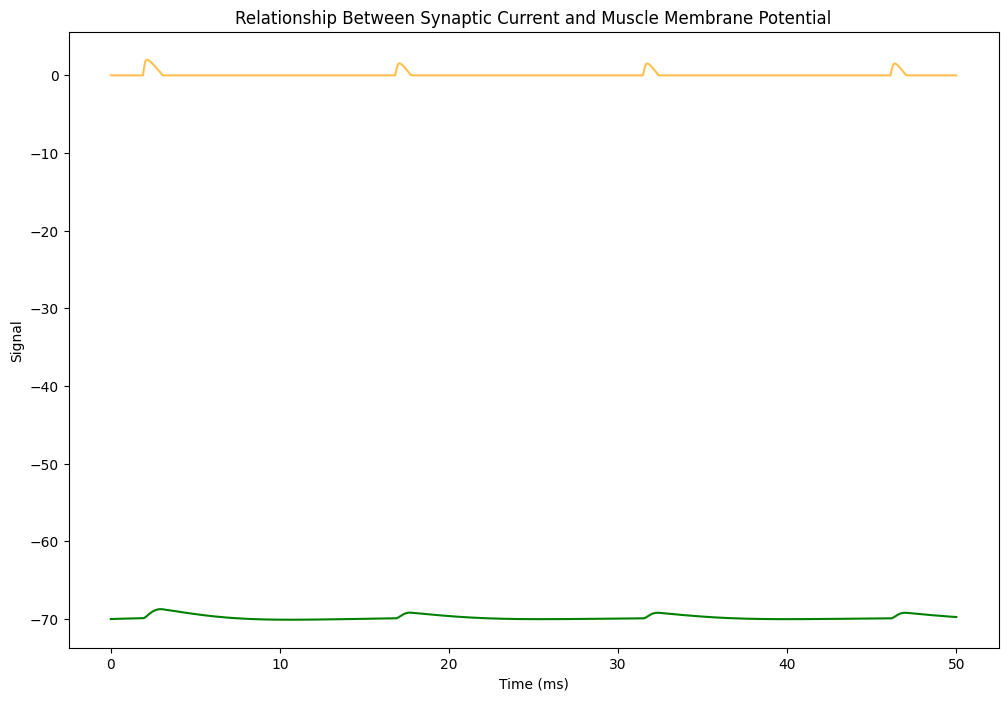

In [3]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt


# Function to analyze action potential
def analyze_action_potential(t, V):
    # Find peaks (local maxima) of the signal
    peaks, _ = find_peaks(V, height=np.mean(V))  # Set threshold to mean value of the signal
    if len(peaks) == 0:  # No peaks found
        print("No peaks detected in the signal.")
        return 0, 0, [], []  # Return zeros and empty lists

    peak_times = t[peaks]
    peak_values = V[peaks]

    # Compute amplitude
    amplitude = np.max(peak_values) - np.min(V)

    # Compute frequency (Hz)
    if len(peak_times) > 1:
        isi = np.diff(peak_times)  # Inter-spike intervals
        frequency = 1 / np.mean(isi)  # Frequency in kHz
    else:
        frequency = 0  # No oscillations

    return amplitude, frequency, peak_times, peak_values


# Analyze neuron action potential
neuron_amplitude, neuron_frequency, neuron_peak_times, neuron_peaks = analyze_action_potential(t, V_neuron)

# Analyze muscle action potential
muscle_amplitude, muscle_frequency, muscle_peak_times, muscle_peaks = analyze_action_potential(t, V_muscle)

# Correlation between synaptic current and muscle action potential
correlation = np.corrcoef(I_synaptic, V_muscle)[0, 1]

# Summary of results
print("Efferent Neuron Action Potential:")
print(f"  Amplitude: {neuron_amplitude:.2f} mV")
print(f"  Frequency: {neuron_frequency * 1000:.2f} Hz")  # Convert from kHz to Hz

print("\nMuscle Fiber Action Potential:")
print(f"  Amplitude: {muscle_amplitude:.2f} mV")
print(f"  Frequency: {muscle_frequency * 1000:.2f} Hz")  # Convert from kHz to Hz

print("\nRelationship between Synaptic Current and Muscle Action Potential:")
print(f"  Correlation: {correlation:.2f}")

# Plot muscle potential and synaptic current for visual analysis
plt.figure(figsize=(12, 8))
plt.plot(t, V_muscle, label="Muscle Membrane Potential (mV)", color="green")
plt.plot(t, I_synaptic, label="Synaptic Current (uA/cm^2)", color="orange", alpha=0.7)
plt.title("Relationship Between Synaptic Current and Muscle Membrane Potential")
plt.xlabel("Time (ms)")
plt.ylabel("Signal")

Example Workflow

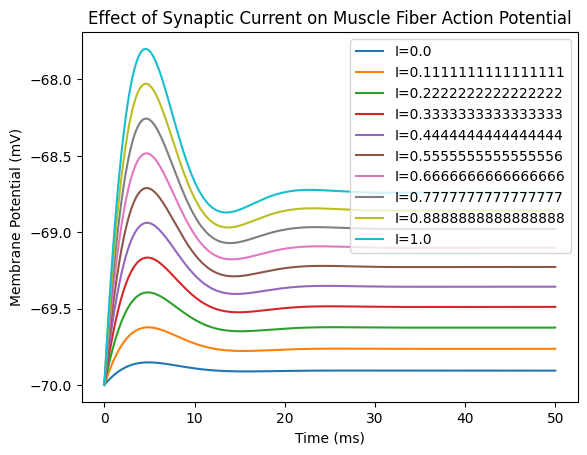

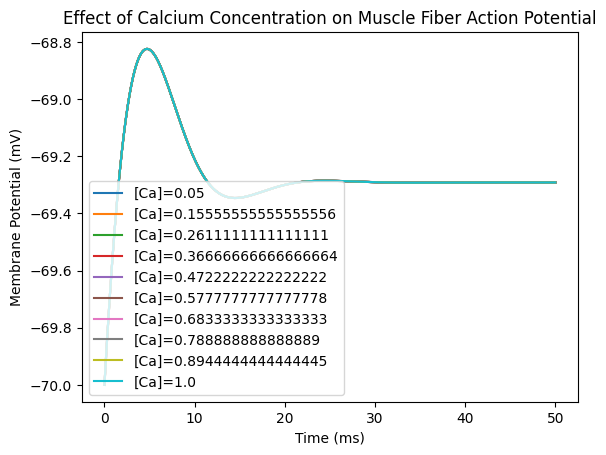

In [4]:
# Case 1: Effect of Synaptic Current Alone
Ca_constant = 0.1  # Fixed calcium concentration
I_syn_range = np.linspace(0, 1, 10)  # Synaptic current variations

for I_syn in I_syn_range:
    # Simulate muscle fiber action potential with fixed calcium
    muscle_solution = odeint(muscle_model, y0_muscle, t, args=(I_syn,))
    V_muscle = muscle_solution[:, 0]
    plt.plot(t, V_muscle, label=f"I={I_syn}")

plt.title("Effect of Synaptic Current on Muscle Fiber Action Potential")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.show()

# Case 2: Effect of Calcium Concentration Alone
I_syn_constant = 0.5  # Fixed synaptic current
Ca_concentration_range = np.linspace(0.05, 1.0, 10)

def update_calcium_parameters(Ca):
  global Ca_rest  # Indicate that we are modifying the global variable
  Ca_rest = Ca  # Update Ca_rest with the new value

for Ca in Ca_concentration_range:
    # Modify the calcium concentration dynamically in the model
    update_calcium_parameters(Ca)  # Hypothetical function
    muscle_solution = odeint(muscle_model, y0_muscle, t, args=(I_syn_constant,))
    V_muscle = muscle_solution[:, 0]
    plt.plot(t, V_muscle, label=f"[Ca]={Ca}")

plt.title("Effect of Calcium Concentration on Muscle Fiber Action Potential")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.show()


Decoupling Analysis

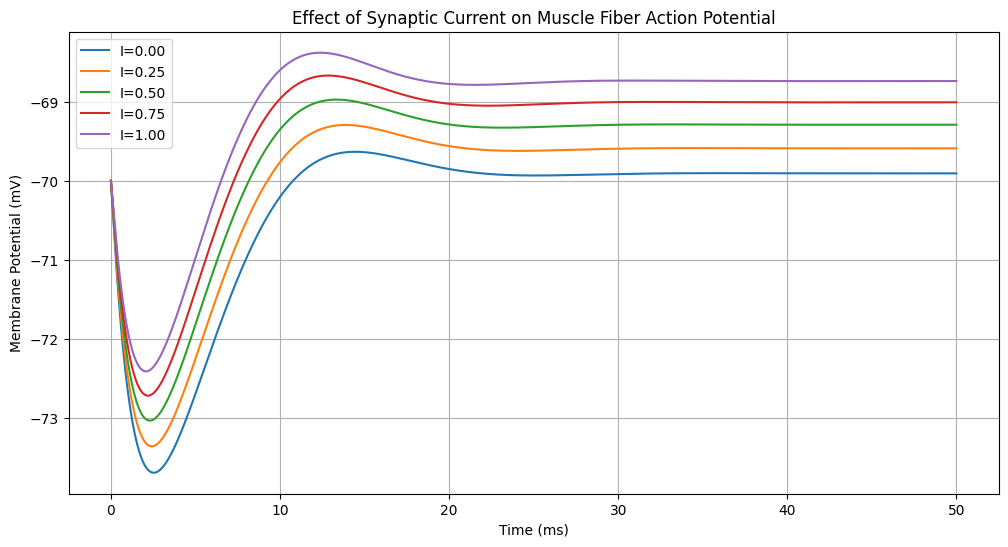

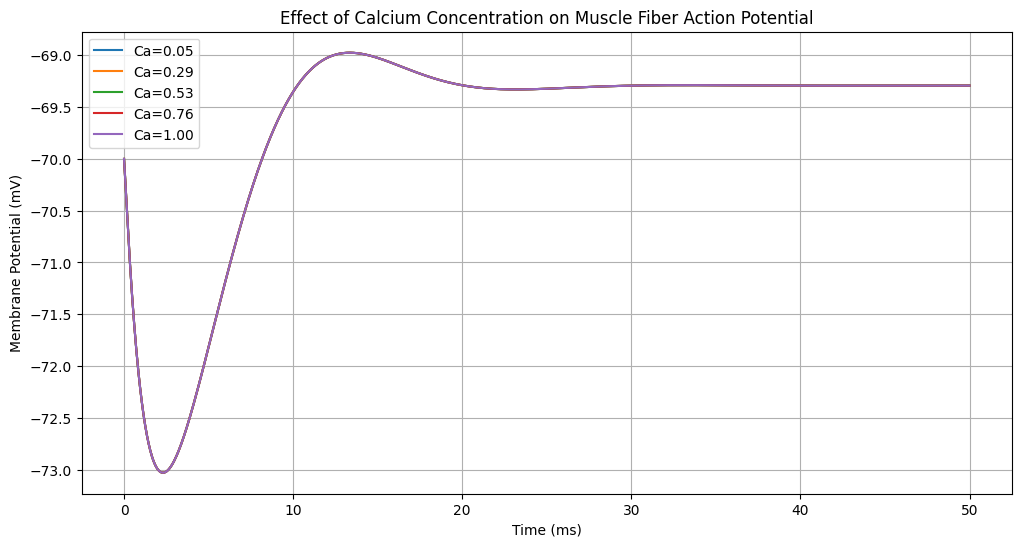

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define a helper function for simulation
def simulate_muscle_action_potential(I_syn, Ca_constant, t, y0):
    """
    Simulates the muscle fiber action potential.
    """
    def muscle_model(y, t, I_syn, Ca):
        V_m, m_m, h_m, n_m, Ca_i = y
        # Calcium dynamics
        dCa_i_dt = -0.1 * Ca_i + 0.01 * (V_m > 0)  # Simplified dynamics
        # Membrane potential dynamics
        dVdt = (I_syn - (g_Na_m * m_m**3 * h_m * (V_m - E_Na_m) +
                         g_K_m * n_m**4 * (V_m - E_K_m) +
                         g_L_m * (V_m - E_L_m))) / C_m
        dmdt = alpha_m(V_m) * (1 - m_m) - beta_m(V_m) * m_m
        dhdt = alpha_h(V_m) * (1 - h_m) - beta_h(V_m) * h_m
        dndt = alpha_n(V_m) * (1 - n_m) - beta_n(V_m) * n_m
        return [dVdt, dmdt, dhdt, dndt, dCa_i_dt]

    # Modify initial conditions for calcium
    y0[-1] = Ca_constant
    # Solve the system
    return odeint(muscle_model, y0, t, args=(I_syn, Ca_constant))

# Simulation parameters
t = np.linspace(0, 50, 2000)  # Time vector (ms)
y0_muscle = [-70.0, 0.05, 0.6, 0.32, 0.1]  # Initial conditions: [V_m, m, h, n, Ca_i]

# Part 1: Effect of Synaptic Current Alone
Ca_constant = 0.1  # Fixed calcium concentration
I_syn_values = np.linspace(0, 1, 5)  # Vary synaptic current
plt.figure(figsize=(12, 6))

for I_syn in I_syn_values:
    result = simulate_muscle_action_potential(I_syn, Ca_constant, t, y0_muscle)
    V_muscle = result[:, 0]
    plt.plot(t, V_muscle, label=f"I={I_syn:.2f}")

plt.title("Effect of Synaptic Current on Muscle Fiber Action Potential")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.grid()
plt.show()

# Part 2: Effect of Calcium Concentration Alone
I_syn_constant = 0.5  # Fixed synaptic current
Ca_values = np.linspace(0.05, 1.0, 5)  # Vary calcium concentration
plt.figure(figsize=(12, 6))

for Ca in Ca_values:
    result = simulate_muscle_action_potential(I_syn_constant, Ca, t, y0_muscle)
    V_muscle = result[:, 0]
    plt.plot(t, V_muscle, label=f"Ca={Ca:.2f}")

plt.title("Effect of Calcium Concentration on Muscle Fiber Action Potential")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.grid()
plt.show()


Sensativety Analysis

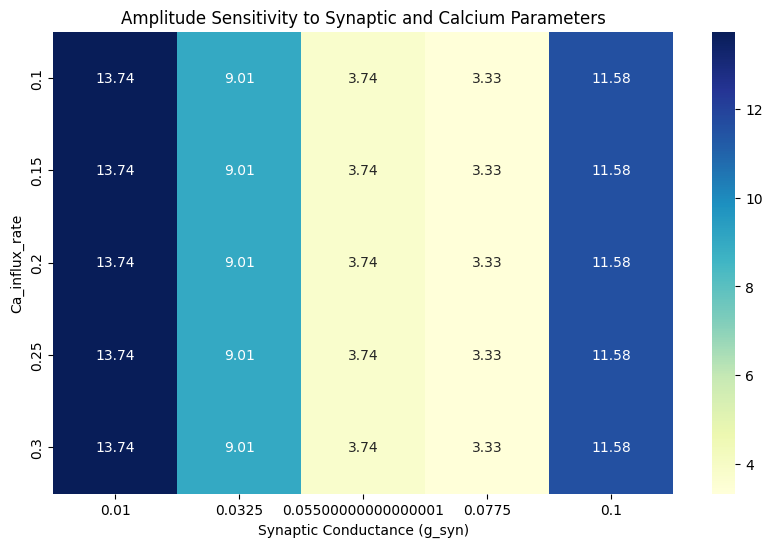

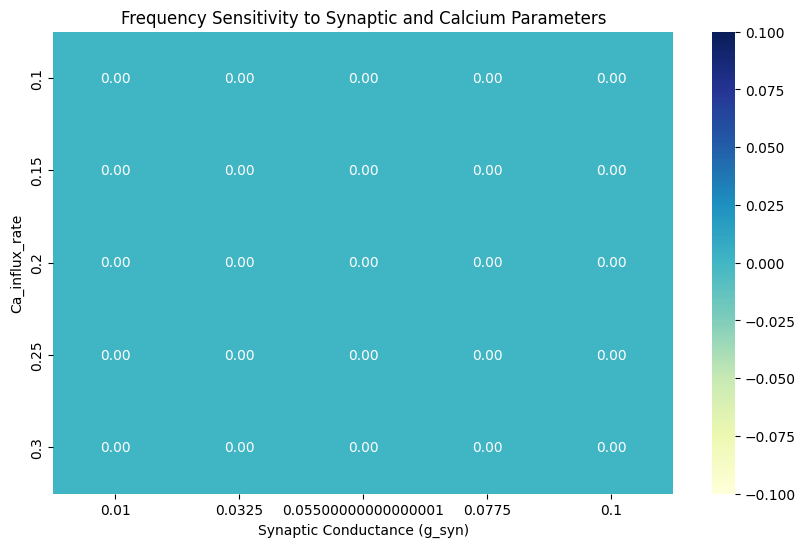

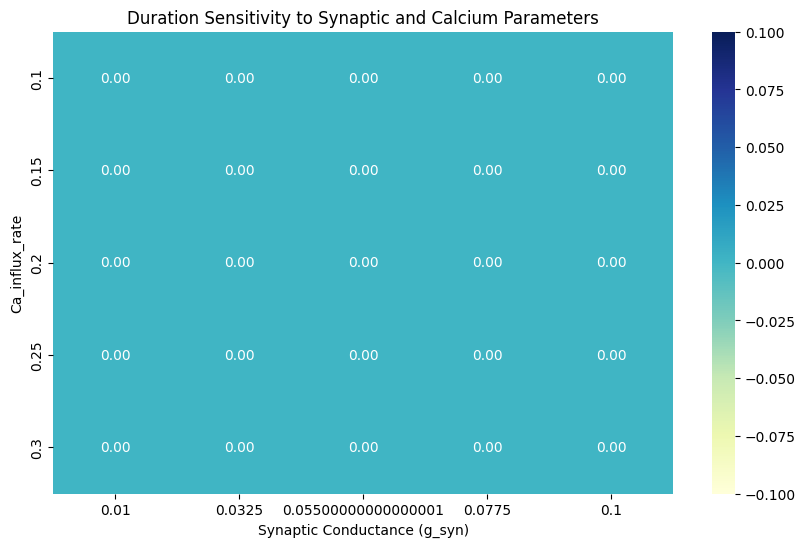

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks
import pandas as pd
import seaborn as sns

# Parameter ranges for sensitivity analysis
Ca_influx_rate_range = np.linspace(0.1, 0.3, 5)  # Calcium influx rate
Ca_decay_rate_range = np.linspace(0.1, 1.0, 5)   # Calcium decay rate
g_syn_range = np.linspace(0.01, 0.1, 5)           # Synaptic conductance range

# Placeholder for results
results = []

# Define muscle model with calcium and synaptic dynamics
def muscle_model_with_calcium_synaptic(y, t, g_syn, Ca_influx_rate, Ca_decay_rate):
    V_m, m_m, h_m, n_m, Ca = y  # Unpack variables

    # Ion channel parameters
    g_Na_m, E_Na_m = 120, 50
    g_K_m, E_K_m = 36, -77
    g_L_m, E_L_m = 0.3, -54.387
    E_syn = 0  # Excitatory reversal potential
    C_m = 1.8

    def alpha_m(V): return 0.1 * (25 - V) / (np.exp((25 - V) / 10) - 1)
    def beta_m(V): return 4.0 * np.exp(-V / 18)
    def alpha_h(V): return 0.07 * np.exp(-V / 20)
    def beta_h(V): return 1 / (np.exp((30 - V) / 10) + 1)
    def alpha_n(V): return 0.01 * (10 - V) / (np.exp((10 - V) / 10) - 1)
    def beta_n(V): return 0.125 * np.exp(-V / 80)

    # Synaptic current
    I_syn = g_syn * (V_m - E_syn)

    # Calcium dynamics
    calcium_influx = Ca_influx_rate * (1 / (1 + np.exp(-0.1 * (V_m + 20))))
    dCa_dt = calcium_influx - Ca_decay_rate * Ca  # Calcium decay

    # Membrane potential dynamics
    dVdt = (I_syn - (
        g_Na_m * m_m**3 * h_m * (V_m - E_Na_m) +
        g_K_m * n_m**4 * (V_m - E_K_m) +
        g_L_m * (V_m - E_L_m))) / C_m
    dmdt = alpha_m(V_m) * (1 - m_m) - beta_m(V_m) * m_m
    dhdt = alpha_h(V_m) * (1 - h_m) - beta_h(V_m) * h_m
    dndt = alpha_n(V_m) * (1 - n_m) - beta_n(V_m) * n_m

    return [dVdt, dmdt, dhdt, dndt, dCa_dt]

# Analyze action potential metrics
def analyze_action_potential_metrics(V_muscle, t):
    peaks, _ = find_peaks(V_muscle, height=0)
    if len(peaks) > 1:
        frequency = 1000 / np.mean(np.diff(t[peaks]))  # ms to Hz
        duration = t[peaks[-1]] - t[peaks[0]]
    else:
        frequency = 0
        duration = 0

    amplitude = np.max(V_muscle) - np.min(V_muscle)
    return amplitude, frequency, duration

# Simulation time and initial conditions
t = np.linspace(0, 100, 5000)  # High-resolution time
y0_muscle_with_calcium = [-70, 0.05, 0.6, 0.32, 0.1]  # Include initial calcium concentration

# Sensitivity analysis
for g_syn in g_syn_range:
    for Ca_influx_rate in Ca_influx_rate_range:
        for Ca_decay_rate in Ca_decay_rate_range:
            # Solve ODE
            result = odeint(muscle_model_with_calcium_synaptic, y0_muscle_with_calcium, t,
                            args=(g_syn, Ca_influx_rate, Ca_decay_rate))

            # Extract membrane potential
            V_muscle = result[:, 0]
            amplitude, frequency, duration = analyze_action_potential_metrics(V_muscle, t)

            # Store results
            results.append((g_syn, Ca_influx_rate, Ca_decay_rate, amplitude, frequency, duration))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['g_syn', 'Ca_influx_rate', 'Ca_decay_rate', 'Amplitude', 'Frequency', 'Duration'])

# Visualization: Heatmaps for Amplitude, Frequency, Duration
def plot_heatmap(df, param, value, title):
    """
    Plots a heatmap with aggregated values to handle duplicate entries.
    """
    # Aggregate the data to ensure unique index-column combinations
    aggregated_df = df.groupby(['g_syn', param])[value].mean().reset_index()

    # Pivot table
    pivot_table = aggregated_df.pivot(index=param, columns='g_syn', values=value)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(title)
    plt.xlabel("Synaptic Conductance (g_syn)")
    plt.ylabel(param)
    plt.show()

# Plot heatmaps for each metric
plot_heatmap(results_df, 'Ca_influx_rate', 'Amplitude', "Amplitude Sensitivity to Synaptic and Calcium Parameters")
plot_heatmap(results_df, 'Ca_influx_rate', 'Frequency', "Frequency Sensitivity to Synaptic and Calcium Parameters")
plot_heatmap(results_df, 'Ca_influx_rate', 'Duration', "Duration Sensitivity to Synaptic and Calcium Parameters")


Temporal Dyanmics Analysis

Min Voltage: -70.0
Max Voltage: -54.4002591373663
Min Voltage: -65.0
Max Voltage: -21.332911055733206


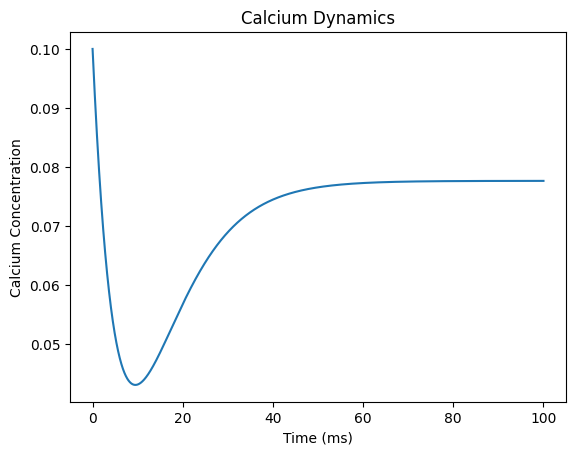

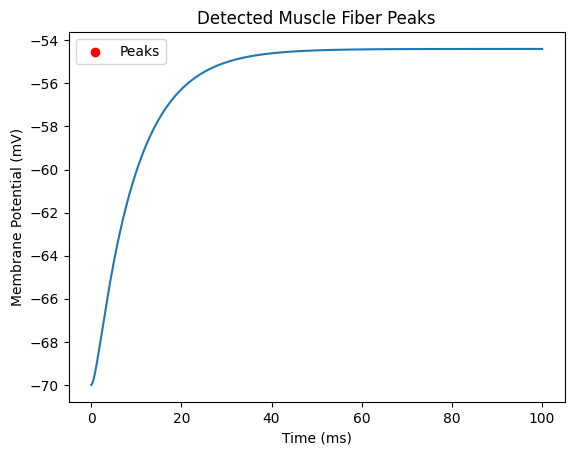

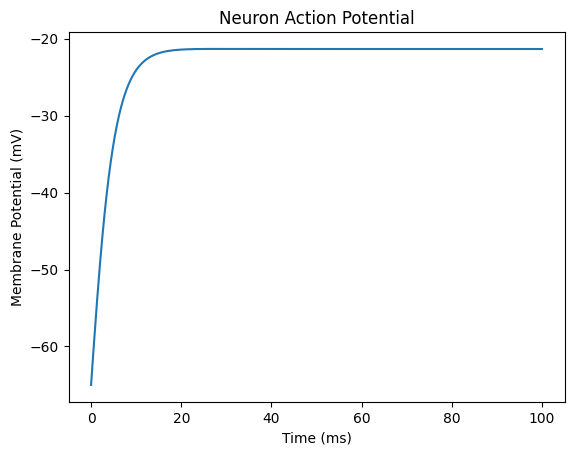

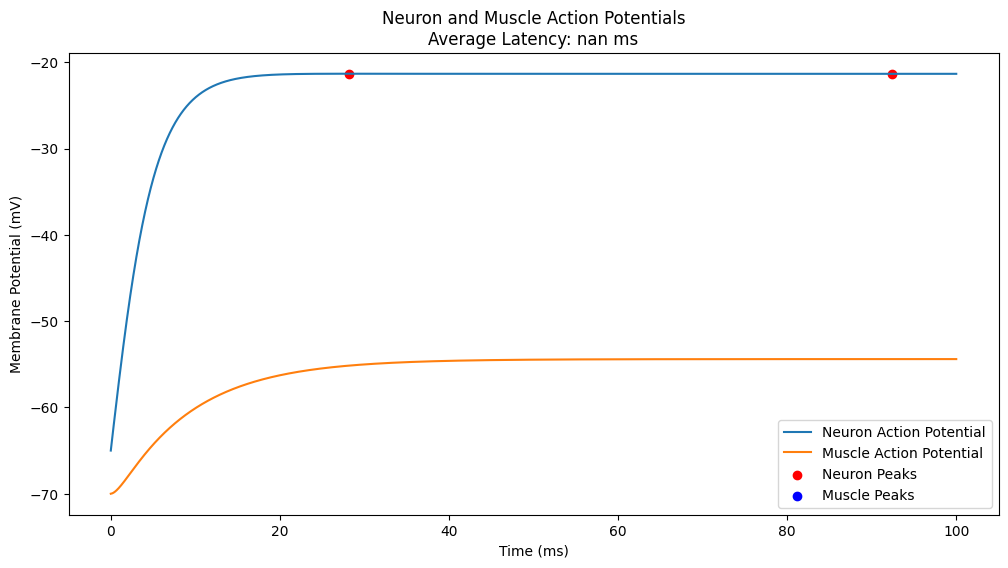

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# Define neuron and muscle models
def neuron_model(y, t, I_ext):
    V_neuron, m_n, h_n, n_n = y  # Neuron state variables

    # Hodgkin-Huxley parameters for neuron
    g_Na_n, E_Na_n = 120, 50
    g_K_n, E_K_n = 36, -77
    g_L_n, E_L_n = 0.3, -54.4
    C_m = 1.0

    def alpha_m(V): return 0.1 * (25 - V) / (np.exp((25 - V) / 10) - 1)
    def beta_m(V): return 4.0 * np.exp(-V / 18)
    def alpha_h(V): return 0.07 * np.exp(-V / 20)
    def beta_h(V): return 1 / (np.exp((30 - V) / 10) + 1)
    def alpha_n(V): return 0.01 * (10 - V) / (np.exp((10 - V) / 10) - 1)
    def beta_n(V): return 0.125 * np.exp(-V / 80)

    dVdt = (I_ext - (
        g_Na_n * m_n**3 * h_n * (V_neuron - E_Na_n) +
        g_K_n * n_n**4 * (V_neuron - E_K_n) +
        g_L_n * (V_neuron - E_L_n))) / C_m
    dmdt = alpha_m(V_neuron) * (1 - m_n) - beta_m(V_neuron) * m_n
    dhdt = alpha_h(V_neuron) * (1 - h_n) - beta_h(V_neuron) * h_n
    dndt = alpha_n(V_neuron) * (1 - n_n) - beta_n(V_neuron) * n_n

    return [dVdt, dmdt, dhdt, dndt]

def muscle_model_with_synapse(y, t, I_syn_func, Ca_influx_rate, Ca_decay_rate):
    V_muscle, m_m, h_m, n_m, Ca = y

    # Muscle fiber parameters
    g_Na_m, E_Na_m = 100, 50
    g_K_m, E_K_m = 40, -77
    g_L_m, E_L_m = 0.2, -54.4
    C_m = 1.8

    def alpha_m(V): return 0.1 * (25 - V) / (np.exp((25 - V) / 10) - 1)
    def beta_m(V): return 4.0 * np.exp(-V / 18)
    def alpha_h(V): return 0.07 * np.exp(-V / 20)
    def beta_h(V): return 1 / (np.exp((30 - V) / 10) + 1)
    def alpha_n(V): return 0.01 * (10 - V) / (np.exp((10 - V) / 10) - 1)
    def beta_n(V): return 0.125 * np.exp(-V / 80)

    # Interpolate synaptic current at time t
    I_syn = I_syn_func(t)

    # Calcium dynamics
    calcium_influx = Ca_influx_rate * (1 / (1 + np.exp(-0.1 * (V_muscle + 20))))
    dCa_dt = calcium_influx - Ca_decay_rate * Ca

    dVdt = (I_syn - (
        g_Na_m * m_m**3 * h_m * (V_muscle - E_Na_m) +
        g_K_m * n_m**4 * (V_muscle - E_K_m) +
        g_L_m * (V_muscle - E_L_m))) / C_m
    dmdt = alpha_m(V_muscle) * (1 - m_m) - beta_m(V_muscle) * m_m
    dhdt = alpha_h(V_muscle) * (1 - h_m) - beta_h(V_muscle) * h_m
    dndt = alpha_n(V_muscle) * (1 - n_m) - beta_n(V_muscle) * n_m

    return [dVdt, dmdt, dhdt, dndt, dCa_dt]

# Time and initial conditions
t = np.linspace(0, 100, 10000)  # 100 ms with high resolution
y0_neuron = [-65, 0.05, 0.6, 0.32]
y0_muscle = [-70, 0.05, 0.6, 0.32, 0.1]

# Simulate neuron action potential
I_ext = 10  # External current to drive neuron firing
neuron_result = odeint(neuron_model, y0_neuron, t, args=(I_ext,))
V_neuron = neuron_result[:, 0]

# Generate synaptic current and interpolate
I_syn = np.maximum(0, V_neuron / 0.001)
I_syn_func = interp1d(t, I_syn, fill_value="extrapolate")  # Interpolation function

# Simulate muscle fiber response
Ca_influx_rate = 0.5
Ca_decay_rate = 0.2
muscle_result = odeint(muscle_model_with_synapse, y0_muscle, t,
                       args=(I_syn_func, Ca_influx_rate, Ca_decay_rate))
V_muscle = muscle_result[:, 0]

#Finding min/max voltage peak
print("Min Voltage:", np.min(V_muscle))
print("Max Voltage:", np.max(V_muscle))

print("Min Voltage:", np.min(V_neuron))
print("Max Voltage:", np.max(V_neuron))

# Analyze timing
muscle_peak_threshold = (np.max(V_muscle) - np.min(V_muscle))

neuron_peaks, _ = find_peaks(V_neuron, height=-55, distance=100)
muscle_peaks, _ = find_peaks(V_muscle, height=muscle_peak_threshold, distance=20)

# Check if peaks were detected
if len(neuron_peaks) == 0 or len(muscle_peaks) == 0:
    print("Warning: No peaks detected in neuron or muscle action potentials.")
    avg_latency = np.nan  # Set to NaN since no latencies can be calculated
else:
    # Match peaks and calculate latencies
    min_peaks = min(len(neuron_peaks), len(muscle_peaks))
    latencies = t[muscle_peaks[:min_peaks]] - t[neuron_peaks[:min_peaks]]
    avg_latency = np.mean(latencies)

# Plot calcium dynamics
plt.plot(t, muscle_result[:, 4])  # Calcium concentration (last variable in result)
plt.title("Calcium Dynamics")
plt.xlabel("Time (ms)")
plt.ylabel("Calcium Concentration")
plt.show()

plt.plot(t, V_muscle)
plt.scatter(t[muscle_peaks], V_muscle[muscle_peaks], color='red', label='Peaks')
plt.legend()
plt.title("Detected Muscle Fiber Peaks")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.show()


plt.plot(t, V_neuron)
plt.title("Neuron Action Potential")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.show()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, V_neuron, label="Neuron Action Potential")
plt.plot(t, V_muscle, label="Muscle Action Potential")
plt.scatter(t[neuron_peaks], V_neuron[neuron_peaks], color='red', label="Neuron Peaks")
plt.scatter(t[muscle_peaks], V_muscle[muscle_peaks], color='blue', label="Muscle Peaks")
plt.legend()
plt.title(f"Neuron and Muscle Action Potentials\nAverage Latency: {avg_latency:.2f} ms")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.show()



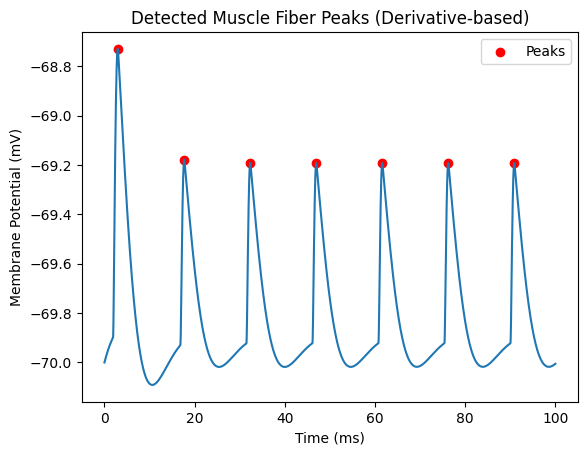

Average Latency: -49.99 ms
Latency Standard Deviation: 24.71 ms
Neuron Firing Frequency: 0.02 Hz
Muscle Firing Frequency: 0.07 Hz
Average Amplitude Difference: -3.54 mV
Amplitude Correlation: 1.00
Neuron Threshold: 100 mV
Muscle Activation Probability: nan%


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


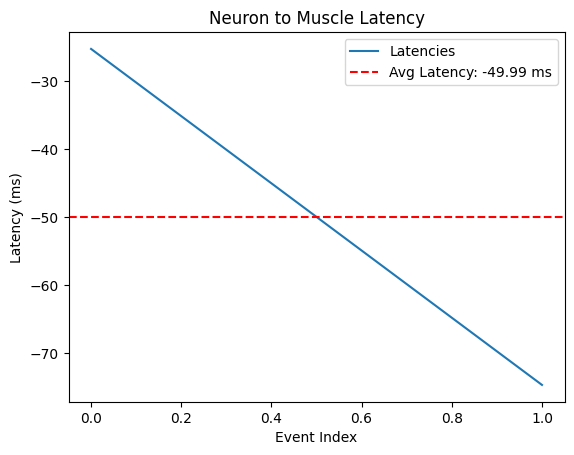

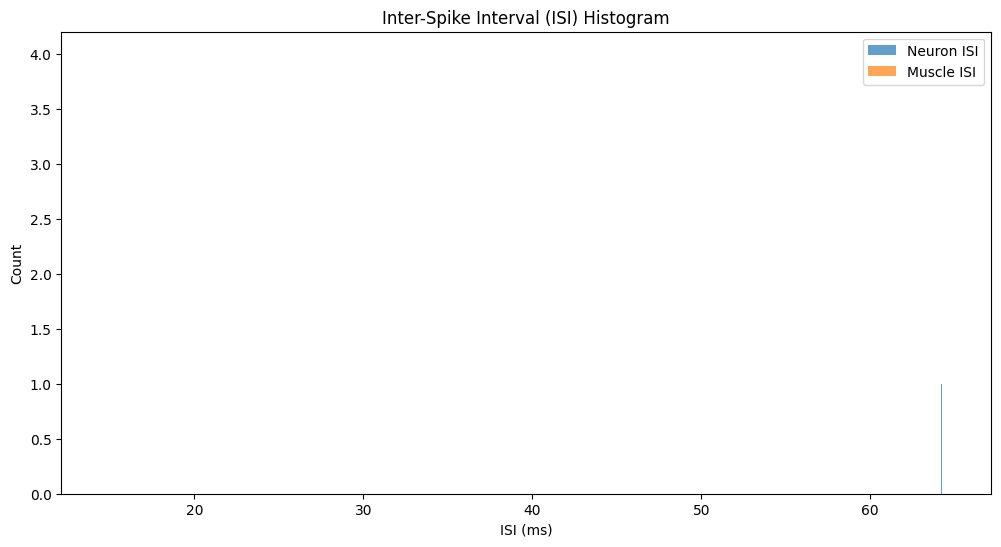

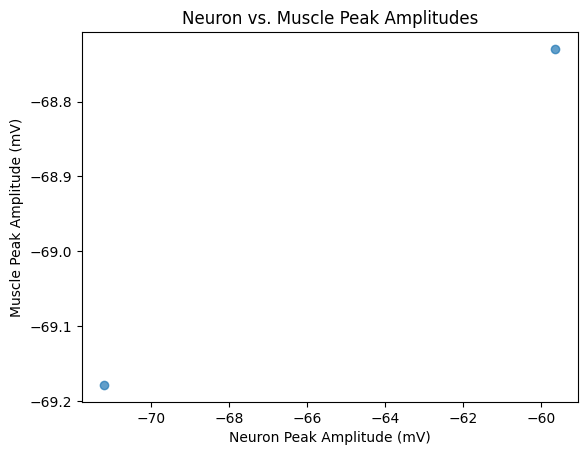

In [8]:
# Constants
C_m = 1.0  # Membrane capacitance, uF/cm^2
g_Na, g_K, g_L = 120.0, 36.0, 0.3  # Conductances for neuron
E_Na, E_K, E_L = 50.0, -77.0, -54.4  # Reversal potentials for neuron
g_syn, E_syn = 0.05, 0.0  # Synaptic parameters

# Muscle fiber parameters
g_Na_m, g_K_m, g_L_m = 100.0, 40.0, 0.2
E_Na_m, E_K_m, E_L_m = 50.0, -85.0, -60.0

# Calcium dynamics parameters
g_Ca = 0.05  # Calcium conductance, mS/cm^2
E_Ca = 120.0  # Calcium reversal potential, mV
tau_Ca = 80.0  # Calcium decay time constant, ms
Ca_rest = 0.0001  # Resting calcium concentration, mM
f_Ca = 0.1  # Scaling factor for calcium influx

# Gating variable functions
def gating_functions(V):
    alpha_m = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta_m = 4.0 * np.exp(-(V + 65) / 18)
    alpha_h = 0.07 * np.exp(-(V + 65) / 20)
    beta_h = 1 / (1 + np.exp(-(V + 35) / 10))
    alpha_n = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta_n = 0.125 * np.exp(-(V + 65) / 80)
    return alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n

# Hodgkin-Huxley neuron model
def hh_model(y, t, I_ext):
    V, m, h, n = y
    alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n = gating_functions(V)
    dVdt = (I_ext - (g_Na * m**3 * h * (V - E_Na) +
                     g_K * n**4 * (V - E_K) +
                     g_L * (V - E_L))) / C_m
    dmdt = alpha_m * (1 - m) - beta_m * m
    dhdt = alpha_h * (1 - h) - beta_h * h
    dndt = alpha_n * (1 - n) - beta_n * n
    return [dVdt, dmdt, dhdt, dndt]

# Muscle fiber model with calcium dynamics
def muscle_model(y, t, I_syn):
    V_m, m_m, h_m, n_m, Ca = y
    alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n = gating_functions(V_m)
    I_Ca = g_Ca * (V_m - E_Ca)  # Voltage-dependent calcium current

    dVdt = (I_syn - (g_Na_m * m_m**3 * h_m * (V_m - E_Na_m) +
                     g_K_m * n_m**4 * (V_m - E_K_m) +
                     g_L_m * (V_m - E_L_m))) / C_m
    dmdt = alpha_m * (1 - m_m) - beta_m * m_m
    dhdt = alpha_h * (1 - h_m) - beta_h * h_m
    dndt = alpha_n * (1 - n_m) - beta_n * n_m
    dCadt = -Ca / tau_Ca + f_Ca * I_Ca
    return [dVdt, dmdt, dhdt, dndt, dCadt]

# Initial conditions
V0, V0_m = -65.0, -70.0  # Resting potentials
alpha_m0, beta_m0, alpha_h0, beta_h0, alpha_n0, beta_n0 = gating_functions(V0)
m0 = alpha_m0 / (alpha_m0 + beta_m0)
h0 = alpha_h0 / (alpha_h0 + beta_h0)
n0 = alpha_n0 / (alpha_n0 + beta_n0)
y0_neuron = [V0, m0, h0, n0]

alpha_m0_m, beta_m0_m, alpha_h0_m, beta_h0_m, alpha_n0_m, beta_n0_m = gating_functions(V0_m)
m0_m = alpha_m0_m / (alpha_m0_m + beta_m0_m)
h0_m = alpha_h0_m / (alpha_h0_m + beta_h0_m)
n0_m = alpha_n0_m / (alpha_n0_m + beta_n0_m)
y0_muscle = [V0_m, m0_m, h0_m, n0_m, Ca_rest]

# Time vector
t = np.linspace(0, 100, 10000)

# External current for neuron
I_ext = 10  # uA/cm^2

# Solve for neuron action potential
neuron_solution = odeint(hh_model, y0_neuron, t, args=(I_ext,))
V_neuron = neuron_solution[:, 0]

# Synaptic current (simple approximation: active when neuron spikes)
def synaptic_current(V_pre):
    return g_syn * (V_pre - E_syn) if V_pre > 0 else 0

I_synaptic = np.array([synaptic_current(V) for V in V_neuron])

# Solve for muscle action potential with calcium dynamics
muscle_solution = np.zeros((len(t), len(y0_muscle)))
muscle_solution[0] = y0_muscle  # Set initial conditions

for i in range(1, len(t)):
    # Use I_synaptic[i-1] to get the current value for the previous time step
    muscle_solution[i] = odeint(
        muscle_model,
        muscle_solution[i-1],
        [t[i-1], t[i]],
        args=(I_synaptic[i-1],)
    )[1]

V_muscle = muscle_solution[:, 0]
Ca_concentration = muscle_solution[:, 4]

## Derivative-based peak detection for muscle fiber action potential
def detect_peaks_with_derivative(signal, threshold=0):
    """Detects peaks by finding zero crossings of the first derivative."""
    derivative = np.diff(signal)
    peaks = []
    for i in range(1, len(derivative)):
        if derivative[i - 1] > 0 and derivative[i] < 0 and signal[i] > threshold:
            peaks.append(i)
    return np.array(peaks, dtype=int) # Convert to integer type


# Detect muscle peaks using the new method
muscle_peaks = detect_peaks_with_derivative(V_muscle, threshold=-70)  # Adjust threshold (mV) if needed


# Plot muscle fiber action potential with detected peaks
plt.plot(t, V_muscle)
plt.scatter(t[muscle_peaks], V_muscle[muscle_peaks], color='red', label='Peaks')
plt.title("Detected Muscle Fiber Peaks (Derivative-based)")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.show()

# Calculate latencies
if len(neuron_peaks) == 0 or len(muscle_peaks) == 0:
    print("Warning: No peaks detected in neuron or muscle action potentials.")
    avg_latency = np.nan
    latency_std = np.nan
else:
    min_peaks = min(len(neuron_peaks), len(muscle_peaks))  # Match corresponding peaks
    latencies = t[muscle_peaks[:min_peaks]] - t[neuron_peaks[:min_peaks]]
    avg_latency = np.mean(latencies)
    latency_std = np.std(latencies)

# Display results
print(f"Average Latency: {avg_latency:.2f} ms")
print(f"Latency Standard Deviation: {latency_std:.2f} ms")


# Calculate inter-spike intervals (ISI) and frequency
neuron_ISI = np.diff(t[neuron_peaks])  # ISI for neuron
muscle_ISI = np.diff(t[muscle_peaks])  # ISI for muscle

# Check for empty ISI arrays before calculating frequency
if neuron_ISI.size > 0:  # Check if neuron_ISI is not empty
    neuron_frequency = 1 / neuron_ISI
    avg_neuron_freq = np.mean(neuron_frequency)
else:
    avg_neuron_freq = np.nan  # Set to NaN if no ISI is calculated

if muscle_ISI.size > 0:  # Check if muscle_ISI is not empty
    muscle_frequency = 1 / muscle_ISI
    avg_muscle_freq = np.mean(muscle_frequency)
else:
    avg_muscle_freq = np.nan  # Set to NaN if no ISI is calculated

# Display results
print(f"Neuron Firing Frequency: {avg_neuron_freq:.2f} Hz")
print(f"Muscle Firing Frequency: {avg_muscle_freq:.2f} Hz")

# Get peak amplitudes
neuron_amplitudes = V_neuron[neuron_peaks]
muscle_amplitudes = V_muscle[muscle_peaks[:len(neuron_amplitudes)]]  # Match peaks

# Calculate peak-to-peak amplitude difference
amplitude_diff = muscle_amplitudes - neuron_amplitudes

# Correlation coefficient
amplitude_correlation = np.corrcoef(neuron_amplitudes, muscle_amplitudes)[0, 1]

# Display results
print(f"Average Amplitude Difference: {np.mean(amplitude_diff):.2f} mV")
print(f"Amplitude Correlation: {amplitude_correlation:.2f}")

# Define a threshold for neuron action potential
neuron_threshold = 100  # mV, example value
neuron_above_threshold = np.where(V_neuron > neuron_threshold)[0]  # Time indices above threshold

# Check corresponding muscle activation
muscle_active = V_muscle[neuron_above_threshold]

# Measure activation probability
activation_probability = np.mean(muscle_active > muscle_peak_threshold)

# Display results
print(f"Neuron Threshold: {neuron_threshold} mV")
print(f"Muscle Activation Probability: {activation_probability:.2%}")

plt.plot(latencies, label="Latencies")
plt.axhline(avg_latency, color='red', linestyle='--', label=f"Avg Latency: {avg_latency:.2f} ms")
plt.title("Neuron to Muscle Latency")
plt.xlabel("Event Index")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(neuron_ISI, bins=10, alpha=0.7, label="Neuron ISI")
plt.hist(muscle_ISI, bins=10, alpha=0.7, label="Muscle ISI")
plt.title("Inter-Spike Interval (ISI) Histogram")
plt.xlabel("ISI (ms)")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.scatter(neuron_amplitudes, muscle_amplitudes, alpha=0.7)
plt.title("Neuron vs. Muscle Peak Amplitudes")
plt.xlabel("Neuron Peak Amplitude (mV)")
plt.ylabel("Muscle Peak Amplitude (mV)")
plt.show()


